# IBM Applied Data Science Capstone

### Final Project

##### Gilberto Agostinho

## 1. Introduction


A housing development company wants to identify what is the best area in London to construct a new building for private owners. Their 3-bedroom apartments are targeted to middle-class families with children. With this in mind, they are looking for a region with ample amenities such as supermarkets, parks, restaurants, cafes, etc. They also prefer a more central area.

In this study, we will consider all London boroughs and the areas that make those up, and look for the most suitable candidates for their project.

## 2. Data


The data used in this project comes from several sources:

1. The list of London areas and their boroughs is obtained from a table from https://en.wikipedia.org/wiki/List_of_areas_of_London
2. The latitude and longitude of these boroughs is obtained using the geocoder library. This information will be used to search for venues within those boroughs.
3. Venue data is obtained using the FourSquare API.

### Scraping the wiki page for a list of Areas and Boroughs

Let's start by loading up the necessary libraries and scrape the wikipedia page above in order to obtain a dataframe with all London areas and boroughs

In [1]:
import pandas as pd
import numpy as np
import json
import requests
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup

In [2]:
# loading and scrapping the url
url = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text
page = BeautifulSoup(url, 'lxml')

# finding the table
table = page.find_all('table')[1] 
df_table = pd.read_html(str(table))

# creating dataframe
df = pd.DataFrame(df_table[0])
df.head(10)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728
5,Aldborough Hatch,Redbridge[9],ILFORD,IG2,020,TQ455895
6,Aldgate,City[10],LONDON,EC3,020,TQ334813
7,Aldwych,Westminster[10],LONDON,WC2,020,TQ307810
8,Alperton,Brent[11],WEMBLEY,HA0,020,TQ185835
9,Anerley,Bromley[11],LONDON,SE20,020,TQ345695


Let's rename those columns into a single word for simplicity. Also, we do not need the dial code nor the OS grid reference numbers, so we can drop those columns.

In [3]:
df.columns = ['Area', 'Borough', 'Town', 'Postcode', 'Dialcode', 'OSgridref']

df.drop(['Dialcode', 'OSgridref'], axis=1, inplace=True)
df.head(10)

,Area,Borough,Town,Postcode
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4"
2,Addington,Croydon[8],CROYDON,CR0
3,Addiscombe,Croydon[8],CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
5,Aldborough Hatch,Redbridge[9],ILFORD,IG2
6,Aldgate,City[10],LONDON,EC3
7,Aldwych,Westminster[10],LONDON,WC2
8,Alperton,Brent[11],WEMBLEY,HA0
9,Anerley,Bromley[11],LONDON,SE20


We must now clean the data of the names of the boroughs. Wikipedia has several numbers in brackets (which leads to links at the bottom of the page), and we can use regex in order to remove those.

In [4]:
import re


pattern = re.compile(r'(.*)\[\d+\]')

for i in range(df.shape[0]):
    try:
        df.loc[i, 'Borough'] = pattern.match(df.loc[i, 'Borough']).group(1).strip()
    except:
        pass
    
df.head(10)

,Area,Borough,Town,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14"
5,Aldborough Hatch,Redbridge,ILFORD,IG2
6,Aldgate,City,LONDON,EC3
7,Aldwych,Westminster,LONDON,WC2
8,Alperton,Brent,WEMBLEY,HA0
9,Anerley,Bromley,LONDON,SE20


Next, let's convert the town names from all caps into title case:

In [5]:
for i in range(df.shape[0]):
    df.loc[i, 'Town'] = df.loc[i, 'Town'].title()
    
df.head(10)

,Area,Borough,Town,Postcode
0,Abbey Wood,"Bexley, Greenwich",London,SE2
1,Acton,"Ealing, Hammersmith and Fulham",London,"W3, W4"
2,Addington,Croydon,Croydon,CR0
3,Addiscombe,Croydon,Croydon,CR0
4,Albany Park,Bexley,"Bexley, Sidcup","DA5, DA14"
5,Aldborough Hatch,Redbridge,Ilford,IG2
6,Aldgate,City,London,EC3
7,Aldwych,Westminster,London,WC2
8,Alperton,Brent,Wembley,HA0
9,Anerley,Bromley,London,SE20


In [6]:
df.shape

(533, 4)

### Acquiring latitude and longitude values for each Area

First, let's import the necessary libraries

In [7]:
!pip install geocoder==1.5.0
import geocoder

We can now loop through our Areas to find their location data (this step takes a long time given that we are dealing with 533 areas and that `geocoder.arcgis()` takes a fair bit of time for each call).

In [8]:
# generating a list of latitudes and longitudes for each post code

lat_list = []
lng_list = []

for area, borough in zip(df['Area'], df['Borough']):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        address = f'{area}, {borough}, London, United Kingdom'
        g = geocoder.arcgis(address)
        lat_lng_coords = g.latlng
    lat_list.append(lat_lng_coords[0])
    lng_list.append(lat_lng_coords[1])

We can now inser those lists of latitude and longitude back into the dataframe

In [9]:
df.insert(3, "Latitude", lat_list) 
df.insert(4, "Longitude", lng_list)
df.head()

,Area,Borough,Town,Latitude,Longitude,Postcode
0,Abbey Wood,"Bexley, Greenwich",London,51.492450,0.12127,SE2
1,Acton,"Ealing, Hammersmith and Fulham",London,51.482690,-0.21291,"W3, W4"
2,Addington,Croydon,Croydon,51.593209,-0.08339,CR0
3,Addiscombe,Croydon,Croydon,51.593209,-0.08339,CR0
4,Albany Park,Bexley,"Bexley, Sidcup",51.435700,0.12588,"DA5, DA14"


Let's visualise all these areas in the map of London. We will colour the dots representing the areas by Borough (so areas in a same borough will share a same colour).

In [10]:
# importing necessary packages
!pip install folium geopy
import folium
import geopy
from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values
import matplotlib
import matplotlib.pyplot as plt

In [11]:
address = 'London, UK'
geolocator = Nominatim(user_agent="london_explorer")
london_location = geolocator.geocode(address)
london_latitude = london_location.latitude
london_longitude = london_location.longitude

# create map of London using latitude and longitude values
map_london = folium.Map(location=(london_latitude, london_longitude), 
                        zoom_start=11,
                        tiles='Stamen Toner',
                        )

# creating a list of all unique borough entries
list_unique_boroughs = df['Borough'].unique()
list_unique_boroughs.sort()

# selecting a colourmap
colourmap = plt.cm.hsv

# add markers to map
for lat, lng, borough, area in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Area']):
    
    borough_index = np.searchsorted(list_unique_boroughs, borough)
    entry_colour = colourmap(borough_index / len(list_unique_boroughs))
    
    label = '{}, {}'.format(area, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color=matplotlib.colors.rgb2hex(entry_colour),
        fill=True,
        fill_color=matplotlib.colors.rgb2hex(entry_colour),
        fill_opacity=0.4,
        parse_html=False).add_to(map_london)  
    
map_london

### Acquiring venue data

We will use the FourSquare API for this

In [12]:
# Adding my Foursquare credentials
CLIENT_ID = 'VPPOU43ZL3EZALEAFZIX4DE0I1V2CM3PBK4IMPFHUKODSDZG' # your Foursquare ID
CLIENT_SECRET = 'QAALV2RS4IX5HDJYA5NDJGRNTQKILI4EPWK1LTN4K1BV2220' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VPPOU43ZL3EZALEAFZIX4DE0I1V2CM3PBK4IMPFHUKODSDZG
CLIENT_SECRET:QAALV2RS4IX5HDJYA5NDJGRNTQKILI4EPWK1LTN4K1BV2220


Let's create a function to repeat the same process to all the areas of London

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results],
        )

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                             'Area Latitude', 
                             'Area Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category',
                             ]
    
    return nearby_venues


Now write the code to run the above function on each London area and create a new dataframe called london_venues. This step is also a bit slow since we are getting 100 entries of venues for each of the 533 areas.

In [14]:
df_venues = getNearbyVenues(names=df['Area'],
                            latitudes=df['Latitude'],
                            longitudes=df['Longitude'],
                            radius=500,
                            )

print(df_venues.shape)

(14397, 7)


In [15]:
df_venues.head()

,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.49245,0.12127,Lesnes Abbey,51.489526,0.125839,Historic Site
1,Abbey Wood,51.49245,0.12127,Sainsbury's,51.492824,0.120724,Supermarket
2,Abbey Wood,51.49245,0.12127,Lidl,51.496152,0.118417,Supermarket
3,Abbey Wood,51.49245,0.12127,Abbey Wood Railway Station (ABW),51.490825,0.123432,Train Station
4,Abbey Wood,51.49245,0.12127,Costcutter,51.491287,0.120938,Convenience Store


### Analysing each Area

Let's start by groupping our data by area and checking the number of unique venue categories per area. Let's then find out the areas with the highest diversity of types of venues.

In [16]:
df_nunique_venues = df_venues.groupby('Area').nunique()[['Venue Category']]
df_nunique_venues.columns = ['Number of Unique Venue Categories']
df_nunique_venues.head()

,Number of Unique Venue Categories
Area,
Abbey Wood,5
Acton,14
Addington,5
Addiscombe,5
Albany Park,4


Let's now find out the top 10 areas with the most diverse categories of venues in London.

In [17]:
df_nunique_venues.sort_values(by=['Number of Unique Venue Categories'], ascending=False, inplace=True)
df_nunique_venues.head(10)

,Number of Unique Venue Categories
Area,
King's Cross,66
Nag's Head,63
Bankside,62
Denmark Hill,59
Fitzrovia,59
Dulwich,59
Camberwell,59
Nunhead,59
Walworth,59


Let's now analyse the individual categories of venues in each area.

In [18]:
df_venues_by_area = df_venues.groupby('Area')['Venue Category'].unique().apply(list).to_frame()
df_venues_by_area.columns = ['List of Venue Categories']
df_venues_by_area.head()

,List of Venue Categories
Area,
Abbey Wood,"[Historic Site, Supermarket, Train Station, Co..."
Acton,"[Pizza Place, Bakery, Café, Pub, Bar, Garden, ..."
Addington,"[Park, Fast Food Restaurant, Supermarket, Café..."
Addiscombe,"[Park, Fast Food Restaurant, Supermarket, Café..."
Albany Park,"[Grocery Store, Train Station, Indian Restaura..."


We can now search for all areas that match our constraints. We can use sublists for equivalent values; that is, any area that passes our initial filtering is required to have some type of market, either a park or a garden, and other amenities such as gyms, museums, pubs, restaurants, cafes, etc.

In [26]:
required_venues = [['Supermarket', 'Market', 'Convenience Store', 'Grocery Store'], 
                   ['Park', 'Garden'],
                   ['Gym'],
                   ['Museum'],
                   ['Pub'],
                   ['Café', 'Restaurant'],
                   ['Train', 'Metro', 'Bus'],
                   ]

ideal_areas = []

for area, _ in df_venues_by_area.iterrows():
    list_of_venues = df_venues_by_area.loc[area, 'List of Venue Categories']
    for required_venue in required_venues:
        if not any(venue in entry for venue in required_venue for entry in list_of_venues):
            break
    else:
        print('***')
        print(area)
        print(list_of_venues)
        ideal_areas.append(area)

***
Chelsea
['Restaurant', 'Soccer Stadium', 'Lounge', 'Music Venue', 'Pub', 'Italian Restaurant', 'Gym / Fitness Center', 'Museum', 'Bagel Shop', 'Café', 'French Restaurant', 'Sporting Goods Shop', 'Sandwich Place', 'Jazz Club', 'Rock Climbing Spot', 'Brazilian Restaurant', 'Grocery Store', 'Creperie', 'Thai Restaurant', 'Speakeasy', 'Park', 'Bakery', 'Soccer Field', 'Antique Shop', 'Coffee Shop', 'Gastropub', 'Hotel', 'Pharmacy', 'Pizza Place', 'Nightclub', 'Bus Stop', 'Performing Arts Venue', 'Sports Bar', 'Sushi Restaurant', 'Seafood Restaurant']
***
Covent Garden
['Art Museum', 'Café', 'Park', 'Salad Place', 'Concert Hall', 'Italian Restaurant', 'Fast Food Restaurant', 'Garden', 'Restaurant', 'Lounge', 'Hotel', 'Sandwich Place', 'Sushi Restaurant', 'Coffee Shop', 'Pub', 'Indian Restaurant', 'Chinese Restaurant', 'Deli / Bodega', 'Hotel Bar', 'Canal Lock', 'Pizza Place', 'Dry Cleaner', 'Tea Room', 'Asian Restaurant', 'Plaza', 'Bar', 'Gift Shop', 'Grocery Store', 'Argentinian Restau

In [53]:
df_ideal_areas = df[df['Area'].isin(ideal_areas)]
df_ideal_areas = df_ideal_areas[df_ideal_areas['Town'] == 'London']
df_ideal_areas

,Area,Borough,Town,Latitude,Longitude,Postcode
91,Chelsea,Kensington and Chelsea,London,51.481980,-0.185500,SW3
114,Covent Garden,Westminster,London,51.493194,-0.128937,WC2
182,Frognal,Camden,London,51.532360,-0.127960,NW3
192,Gospel Oak,Camden,London,51.532360,-0.127960,"NW5, NW3"
238,Highbury,Islington,London,51.546240,-0.103270,N5
252,Hoxton,Hackney,London,51.544888,-0.059541,N1
429,St James's,Westminster,London,51.491190,-0.134820,SW1
431,St Giles,Camden,London,51.532360,-0.127960,WC2
470,Tufnell Park,"Islington, Camden",London,51.532360,-0.127960,"N7, N19"


In [54]:
address = 'London, UK'
geolocator = Nominatim(user_agent="london_explorer")
london_location = geolocator.geocode(address)
london_latitude = london_location.latitude
london_longitude = london_location.longitude

# create map of London using latitude and longitude values
map_london = folium.Map(location=(london_latitude, london_longitude), 
                        zoom_start=13,
                        tiles='Stamen Toner',
                        )

# creating a list of all unique borough entries
list_unique_boroughs = df['Borough'].unique()
list_unique_boroughs.sort()

# selecting a colourmap
colourmap = plt.cm.hsv

# add markers to map
for lat, lng, borough, area in zip(df_ideal_areas['Latitude'], df_ideal_areas['Longitude'], df_ideal_areas['Borough'], df_ideal_areas['Area']):
    
    borough_index = np.searchsorted(list_unique_boroughs, borough)
    entry_colour = colourmap(borough_index / len(list_unique_boroughs))
    
    label = '{}, {}'.format(area, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color=matplotlib.colors.rgb2hex(entry_colour),
        fill=True,
        fill_color=matplotlib.colors.rgb2hex(entry_colour),
        fill_opacity=0.4,
        parse_html=False).add_to(map_london)  
    
map_london

In [32]:
! pip install mpu
from mpu import haversine_distance

In [45]:
df_ideal_areas.insert(6, "Distance to Centre", np.nan) 
df_ideal_areas.head()

,Area,Borough,Town,Latitude,Longitude,Postcode,Distance to Centre
91,Chelsea,Kensington and Chelsea,London,51.481980,-0.185500,SW3,NaN
114,Covent Garden,Westminster,London,51.493194,-0.128937,WC2,NaN
182,Frognal,Camden,London,51.532360,-0.127960,NW3,NaN
192,Gospel Oak,Camden,London,51.532360,-0.127960,"NW5, NW3",NaN
238,Highbury,Islington,London,51.546240,-0.103270,N5,NaN


In [46]:
df_ideal_areas.set_index('Area', inplace=True)
df_ideal_areas.head()

,Borough,Town,Latitude,Longitude,Postcode,Distance to Centre
Area,,,,,,
Chelsea,Kensington and Chelsea,London,51.481980,-0.185500,SW3,NaN
Covent Garden,Westminster,London,51.493194,-0.128937,WC2,NaN
Frognal,Camden,London,51.532360,-0.127960,NW3,NaN
Gospel Oak,Camden,London,51.532360,-0.127960,"NW5, NW3",NaN
Highbury,Islington,London,51.546240,-0.103270,N5,NaN


In [47]:
for lat, lng, borough, area in zip(df_ideal_areas['Latitude'], df_ideal_areas['Longitude'], df_ideal_areas['Borough'], df_ideal_areas.index):
    distance = haversine_distance((london_latitude, london_longitude),
                                  (lat, lng),
                                  )
    df_ideal_areas.loc[area, "Distance to Centre"] = distance
    
df_ideal_areas.head()

,Borough,Town,Latitude,Longitude,Postcode,Distance to Centre
Area,,,,,,
Chelsea,Kensington and Chelsea,London,51.481980,-0.185500,SW3,4.897036
Covent Garden,Westminster,London,51.493194,-0.128937,WC2,1.573487
Frognal,Camden,London,51.532360,-0.127960,NW3,2.784194
Gospel Oak,Camden,London,51.532360,-0.127960,"NW5, NW3",2.784194
Highbury,Islington,London,51.546240,-0.103270,N5,4.644485


In [49]:
df_ideal_areas.sort_values(by='Distance to Centre', ascending=True, inplace=True)
df_ideal_areas

,Borough,Town,Latitude,Longitude,Postcode,Distance to Centre
Area,,,,,,
Covent Garden,Westminster,London,51.493194,-0.128937,WC2,1.573487
St James's,Westminster,London,51.491190,-0.134820,SW1,1.861230
Frognal,Camden,London,51.532360,-0.127960,NW3,2.784194
Gospel Oak,Camden,London,51.532360,-0.127960,"NW5, NW3",2.784194
St Giles,Camden,London,51.532360,-0.127960,WC2,2.784194
Tufnell Park,"Islington, Camden",London,51.532360,-0.127960,"N7, N19",2.784194
Highbury,Islington,London,51.546240,-0.103270,N5,4.644485
Chelsea,Kensington and Chelsea,London,51.481980,-0.185500,SW3,4.897036
Hoxton,Hackney,London,51.544888,-0.059541,N1,6.296719


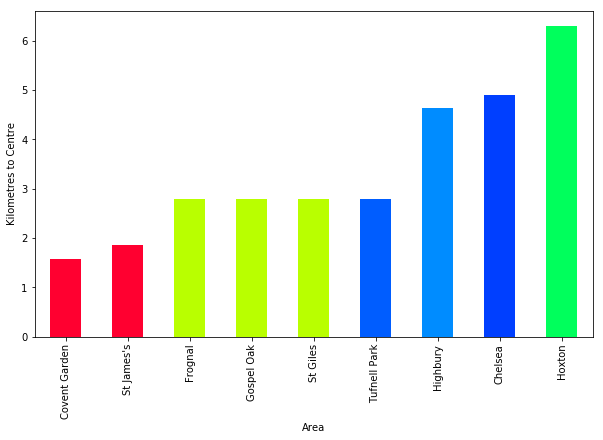

In [50]:
# colouring according to borrough colours used in the first map
colour_list = []
for borough in df_ideal_areas['Borough']:
    borough_index = np.searchsorted(list_unique_boroughs, borough)
    entry_colour = colourmap(borough_index / len(list_unique_boroughs))
    colour_list.append(entry_colour)
    
df_ideal_areas['Distance to Centre'].plot(kind='bar', figsize=(10, 6), color=colour_list)
plt.ylabel('Kilometres to Centre')
plt.show()

From the graph above, we can see that either Holborn or St James's are areas that our client should consider. Both are within 2km of the centre of London, and both have all the required amenities.